# Выделение именованных сущностей в тексте с помощью BERT

Воспользовавшись библиотекой Transformers, загрузим предобученную модель BERT Base и дообучим её для распознавания именованных сущностей.

Для дообучения модели воспользуемся готовым датасетом [WiNER](https://www.aclweb.org/anthology/I17-1042). Это размеченный датасет, созданный из некоторых статей русской Википедии.

Теги датасета (используется BIO-разметка):
* LOC - локация;
* MISC - общие термины;
* ORG - наименование организации;
* PER - имя человека.



## Библиотеки

In [0]:
pip install transformers seqeval

In [0]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig
from transformers import BertForTokenClassification, AdamW
from transformers import get_linear_schedule_with_warmup

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from seqeval.metrics import f1_score, classification_report

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

import seaborn as sns

sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

In [0]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)

print(device.type)
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))

cuda
Tesla P100-PCIE-16GB


## Датасет

Загрузим размеченный корпус:

In [0]:
!wget -O '/content/drive/My Drive/colab_data/NER/data/aij-wikiner-ru-wp3.bz2' https://github.com/dice-group/FOX/raw/master/input/Wikiner/aij-wikiner-ru-wp3.bz2

In [0]:
!bunzip2 '/content/drive/My Drive/colab_data/NER/data/aij-wikiner-ru-wp3.bz2'

In [0]:
!head '/content/drive/My Drive/colab_data/NER/data/aij-wikiner-ru-wp3'

Преобразуем загруженный датасет в удобный для работы вид.

In [0]:
sentences, labels = [], []
tag_values = set()
with open('/content/drive/My Drive/colab_data/NER/data/aij-wikiner-ru-wp3') as df:
    for line in df:
        sent_w = []
        sent_t = []
        sent = line.split()
        for s in sent:
            tag = s.split('|')
            sent_w.append(tag[0])
            sent_t.append(tag[2])
            if len(tag[2]) > 0:
                tag_values.update([tag[2]])
        if len(sent_w) == len(sent_t) and len(sent_w) > 0:
            sentences.append(sent_w)
            labels.append(sent_t)

In [0]:
assert len(sentences) == len(labels)

Количество сэмплов в нашей выборке:

In [0]:
len(sentences)

203287

Посмотрим на один из примеров.

Как видим, наш датасет не очень качественный. Так, например, токен `'Латвией'` помечен как `'I-LOC'`, хотя должен был бы быть помечен как `'B-LOC'`, но для нашего эксперимента такие данные тоже подойдут.

In [0]:
print(sentences[0])
print(labels[0])

['На', 'севере', 'граничит', 'с', 'Латвией', ',', 'на', 'востоке', '--', 'с', 'Белоруссией', ',', 'на', 'юго-западе', '--', 'c', 'Польшей', 'и', 'Калининградской', 'областью', 'России', '.']
['O', 'O', 'O', 'O', 'I-LOC', 'O', 'O', 'O', 'O', 'O', 'I-LOC', 'O', 'O', 'O', 'O', 'O', 'I-LOC', 'O', 'I-LOC', 'I-LOC', 'B-LOC', 'O']


Существующие метки:

In [0]:
tag_values

{'B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O'}

In [0]:
tag_values = list(tag_values)
tag_values.append('PAD')
tag2idx = {t: i for i, t in enumerate(tag_values)}

In [0]:
tag2idx

{'B-LOC': 1,
 'B-MISC': 8,
 'B-ORG': 0,
 'B-PER': 5,
 'I-LOC': 2,
 'I-MISC': 4,
 'I-ORG': 6,
 'I-PER': 7,
 'O': 3,
 'PAD': 9}

## Токенизация

Загрузим токенизатор:

In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

Токенизатор Берта использует subword-токенизацию, поэтому нам нужно будет расширить наши метки до размера токенизированного текста. (Для качественного датасета этот метод придётся немного изменить, но для нашей проверки возможностей Берта для NER мы делаем упрощение).

In [0]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Токенизируем слово, посчитаем кол-во токенов в слове
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Добавим токены в общую последовательность токенов предложения
        tokenized_sentence.extend(tokenized_word)

        # Расшимим текущую метку до кол-во токенов в слове и добавим её в общую последовательность
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [10]:
%%time
tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sentences, labels)
]

CPU times: user 2min 32s, sys: 1.11 s, total: 2min 34s
Wall time: 2min 34s


Теперь каждому токену соответствует определённая метка.

In [0]:
print(tokenized_texts_and_labels[0])

(['Н', '##а', 'с', '##е', '##в', '##е', '##р', '##е', 'г', '##р', '##а', '##н', '##и', '##ч', '##и', '##т', 'с', 'Л', '##а', '##т', '##в', '##и', '##е', '##й', ',', 'н', '##а', 'в', '##о', '##с', '##т', '##о', '##к', '##е', '-', '-', 'с', 'Б', '##е', '##л', '##о', '##р', '##у', '##с', '##с', '##и', '##е', '##й', ',', 'н', '##а', 'ю', '##г', '##о', '-', 'з', '##а', '##п', '##а', '##д', '##е', '-', '-', 'c', 'П', '##о', '##л', '##ь', '##ш', '##е', '##й', 'и', 'К', '##а', '##л', '##и', '##н', '##и', '##н', '##г', '##р', '##а', '##д', '##с', '##к', '##о', '##й', 'о', '##б', '##л', '##а', '##с', '##т', '##ь', '##ю', 'Р', '##о', '##с', '##с', '##и', '##и', '.'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'O', 'O', 'O', 'O', 'O

Определим размер входной последовательности. Максимальная длина последовательности, подаваемая Берту, - 512 токенов. Мы же определим свою длину для оптимизации вычислений.

In [0]:
lenths = [len(sent) for sent, _ in tokenized_texts_and_labels]

In [16]:
print(min(lenths), np.mean(lenths), max(lenths), sep='|')

1|84.73471495963834|1031


Посмотрим, как распределяются длины наших токенов:

(array([1.46017e+05, 5.15310e+04, 5.07900e+03, 5.61000e+02, 7.50000e+01,
        1.60000e+01, 4.00000e+00, 1.00000e+00, 1.00000e+00, 2.00000e+00]),
 array([1.000e+00, 1.040e+02, 2.070e+02, 3.100e+02, 4.130e+02, 5.160e+02,
        6.190e+02, 7.220e+02, 8.250e+02, 9.280e+02, 1.031e+03]),
 <a list of 10 Patch objects>)

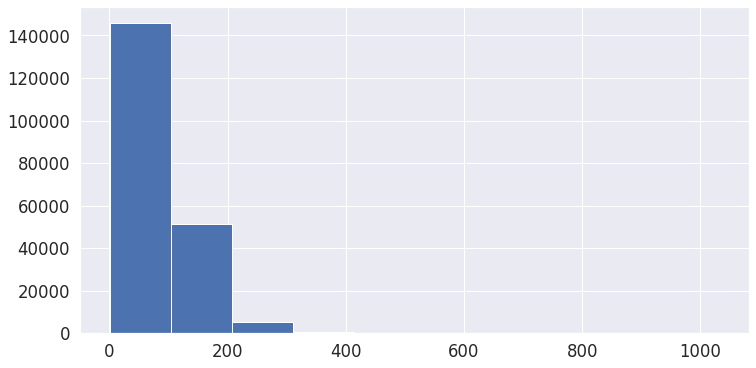

In [13]:
plt.hist(lenths)

In [0]:
# Cделаем размер последовательности 200
MAX_LEN = 200
# Батч, рекомендуемый разработчиками Берта - 32
BATCH_SIZE = 32

In [0]:
tokenized_texts = [token for token, _ in tokenized_texts_and_labels]
labels = [label for _, label in tokenized_texts_and_labels]

assert len(tokenized_texts) == len(labels)

In [0]:
print(tokenized_texts[0])
print(labels[0])

['Н', '##а', 'с', '##е', '##в', '##е', '##р', '##е', 'г', '##р', '##а', '##н', '##и', '##ч', '##и', '##т', 'с', 'Л', '##а', '##т', '##в', '##и', '##е', '##й', ',', 'н', '##а', 'в', '##о', '##с', '##т', '##о', '##к', '##е', '-', '-', 'с', 'Б', '##е', '##л', '##о', '##р', '##у', '##с', '##с', '##и', '##е', '##й', ',', 'н', '##а', 'ю', '##г', '##о', '-', 'з', '##а', '##п', '##а', '##д', '##е', '-', '-', 'c', 'П', '##о', '##л', '##ь', '##ш', '##е', '##й', 'и', 'К', '##а', '##л', '##и', '##н', '##и', '##н', '##г', '##р', '##а', '##д', '##с', '##к', '##о', '##й', 'о', '##б', '##л', '##а', '##с', '##т', '##ь', '##ю', 'Р', '##о', '##с', '##с', '##и', '##и', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'O', 'O', 'O', 'O', 'O',

Приведём все наши последовательности к единому виду, добавив паддинги к коротким последовательностям, или обрезав длинные последовательности до максимально заданной величины.

In [0]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN,
                          dtype='long',
                          value=0.0,
                          truncating='post',
                          padding='post')

In [0]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN,
                     value=tag2idx['PAD'],
                     padding='post',
                     dtype='long',
                     truncating='post')

Посмотрим, что у нас получилось.

In [0]:
input_ids[0], tags[0]

(array([  460, 10286,   492, 19692, 28394, 19692, 20442, 19692,   478,
        20442, 10286, 17127, 17424, 28409, 17424, 28404,   492,   458,
        10286, 28404, 28394, 17424, 19692, 17106,   117,   488, 10286,
          477, 16948, 28403, 28404, 16948, 28399, 19692,   118,   118,
          492,   449, 19692, 28400, 16948, 20442, 28405, 28403, 28403,
        17424, 19692, 17106,   117,   488, 10286,   505, 28395, 16948,
          118,   482, 10286, 28402, 10286, 28396, 19692,   118,   118,
          172,   462, 16948, 28400, 28414, 28410, 19692, 17106,   483,
          457, 10286, 28400, 17424, 17127, 17424, 17127, 28395, 20442,
        10286, 28396, 28403, 28399, 16948, 17106,   489, 28393, 28400,
        10286, 28403, 28404, 28414, 28416,   463, 16948, 28403, 28403,
        17424, 17424,   119,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
      

In [0]:
# Маска для игнорирования паддингов
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

Разобьём наш датасет на обучающую и тестовую подвыборки.

In [0]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=42, test_size=0.02)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=42, test_size=0.02)

Переведём всё в тензоры

In [0]:
# To Tensor
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

Инициализируем DataLoader'ы:

In [0]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=BATCH_SIZE)

## Дообучение модели

Загрузим предобученную модель BERT Base и дообучим её на наших данных.

In [0]:
model = BertForTokenClassification.from_pretrained(
    'bert-base-cased',
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)

Параметры модели:

In [0]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

In [0]:
model.to(device);

In [0]:
epochs = 4
max_grad_norm = 1.0

Шэдулер для изменения learning rate.

В ходе обучения модели рекомендуется изменять learning rate. В Pytorch имеется несколько методов изменения LR.


In [0]:
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

Подсчёт точности

In [0]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=2).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Обучение

In [0]:
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc='Epoch'):
    model.train()
    total_loss = 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        model.zero_grad()

        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_labels)

        loss = outputs[0]
        loss.backward()

        total_loss += loss.item()

        # clip_grad_norm_ помогает против взрыва градиентов
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)

        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print("Средний лосс обучения: {}".format(avg_train_loss))

    loss_values.append(avg_train_loss)

    # Валидация
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []

    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask,
                            labels=b_labels)
            
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        eval_loss += outputs[0].mean().item()
        eval_accuracy += flat_accuracy(logits, label_ids)
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

        nb_eval_examples += b_input_ids.size(0)
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    validation_loss_values.append(eval_loss)
    print("Лосс на валидации: {}".format(eval_loss))
    print("Accuracy на валидации: {}".format(eval_accuracy/nb_eval_steps))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    print("F1 на валидации: {}".format(f1_score(valid_tags, pred_tags)))
    print()

## Оценка качества
Посмотрим на метрики нашей обученной модели:

In [0]:
print(classification_report(valid_tags, pred_tags))

           precision    recall  f1-score   support

      LOC       0.90      0.92      0.91      3142
     MISC       0.81      0.81      0.81      1599
      PER       0.89      0.91      0.90      1440
      ORG       0.83      0.88      0.85       746

micro avg       0.87      0.89      0.88      6927
macro avg       0.87      0.89      0.88      6927



Посмотрим, как изменялся лосс в ходе обучения

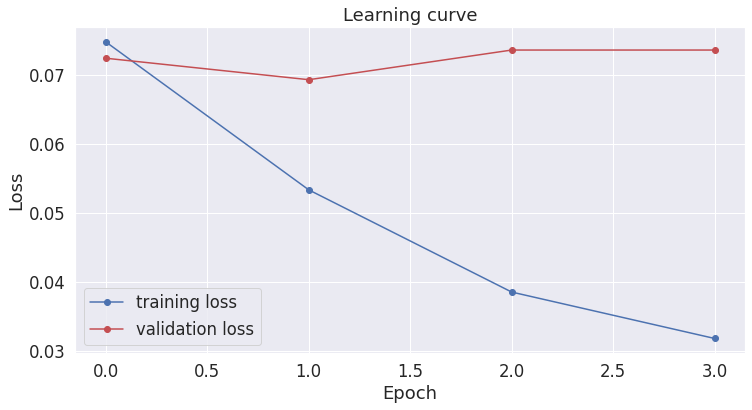

In [0]:
plt.plot(loss_values, 'b-o', label='training loss')
plt.plot(validation_loss_values, 'r-o', label='validation loss')

plt.title('Learning curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

Из графика видно, что для обучения модели на нашем датасете достаточно лишь одной эпохи. Потом - происходит небольшое переобучение.

Сохраним модель:

In [0]:
!mkdir '/content/drive/My Drive/colab_data/NER/model'

In [0]:
model.save_pretrained('/content/drive/My Drive/colab_data/NER/model')
tokenizer.save_pretrained('/content/drive/My Drive/colab_data/NER/model')

('/content/drive/My Drive/colab_data/NER/model/vocab.txt',
 '/content/drive/My Drive/colab_data/NER/model/special_tokens_map.json',
 '/content/drive/My Drive/colab_data/NER/model/added_tokens.json')

Посмотрим вживую, как модель размечает текст:

In [0]:
test_sentence = """
Судно-трубоукладчик «Академик Черский», которое рассматривали как один 
из вариантов завершения строительства газопровода «Северный поток — 2», 
указало курс на Находку. Об этом информирует 
РИА Новости со ссылкой на данные порталов по отслеживанию судов 
Marine Traffic и Vesselfinder.
"""

In [0]:
tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).cuda()

In [0]:
with torch.no_grad():
    output = model(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

In [0]:
# объединяем токены и метки
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)

In [0]:
for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))

O	[CLS]
I-MISC	Судно
O	-
O	трубоукладчик
O	«
I-MISC	Академик
I-MISC	Черский
O	»
O	,
O	которое
O	рассматривали
O	как
O	один
O	из
O	вариантов
O	завершения
O	строительства
O	газопровода
O	«
I-MISC	Северный
I-MISC	поток
I-MISC	—
I-MISC	2
O	»
O	,
O	указало
O	курс
O	на
I-MISC	Находку
O	.
O	Об
O	этом
O	информирует
I-ORG	РИА
I-ORG	Новости
O	со
O	ссылкой
O	на
O	данные
O	порталов
O	по
O	отслеживанию
O	судов
I-MISC	Marine
I-MISC	Traffic
O	и
I-MISC	Vesselfinder
O	.
O	[SEP]
